In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
#!pip install iterative-stratification
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
import lightgbm as lgb
import catboost as ctb
from catboost import *
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [6]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [7]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [8]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [9]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [10]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [11]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [12]:
len(features), len(knn_features)

(2259, 512)

In [13]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [14]:
len(features), len(knn_features)

(309, 62)

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    features.remove(mcol)

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

    features.append(mcol)

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-15-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-15-532bdd304887>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:03<03:53,  3.82s/it]<ipython-input-15-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,MCARI2,Green,DSWI_5,Chlred_edge,SLAVI,SAVI,NormG,DVIMSS,Landsat_num,H,...,NDVI,SWIR1,TIRS2,NBR2,NLI,RDVI,DSWI,Alteration,sunElevation,AVI
0,1.024100,24.466267,-1.589210,2.733582,55.834898,-0.676338,0.593065,-1.499917,7.0,1.536542,...,-0.464321,0.274631,8.218559,0.369581,0.243821,-1.902453,2.304861,2.172491,37.602194,-15.589754
1,0.552047,72.848259,-0.043684,0.724878,3658.334622,0.238271,0.375158,117.831956,7.0,1.410671,...,0.159502,6.375916,8.658948,0.724646,0.979600,1.756928,2.496108,6.263373,65.778748,38.705406
2,0.782590,34.678707,-1.404554,2.362776,145.440316,-0.596540,0.568682,0.291149,7.0,1.532755,...,-0.405253,0.640860,8.255633,0.697570,0.535998,-2.078368,2.222647,5.613106,34.908817,-21.318088
3,0.129308,46.825167,-0.626926,1.554244,868.810277,-0.263694,0.448051,26.308228,7.0,1.495565,...,-0.177638,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855
4,3.224675,30.404083,-2.558995,2.216966,44.545636,-0.548395,0.678692,0.818969,7.0,1.554811,...,-0.378296,0.213160,8.375682,0.710619,0.337366,-1.435234,3.442151,5.911293,34.702091,-10.890392
5,0.129308,46.825167,-0.626926,1.554244,868.810277,-0.263694,0.448051,26.308228,7.0,1.495565,...,-0.177638,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855
6,1.082886,30.243046,-1.533611,2.341471,96.938546,-0.588467,0.585189,0.375503,7.0,1.540411,...,-0.401461,0.514640,8.259885,0.709369,0.465244,-1.858805,2.359482,5.881573,34.908817,-17.212898
7,4.088720,55.338951,-2.511033,3.703350,101.353342,-0.844921,0.693033,-6.792398,8.0,1.554245,...,-0.574771,0.662898,7.987241,0.634860,0.169172,-2.845638,3.033152,4.477353,61.004844,-28.176980
8,1.437299,38.484325,-1.647455,2.203177,142.997158,-0.552662,0.599942,1.576855,7.0,1.551772,...,-0.375620,0.846053,9.141788,0.620597,0.568627,-1.902817,2.513713,4.271438,58.783982,-19.278593
9,1.608101,26.254721,-1.765473,2.376309,57.407128,-0.593507,0.613599,0.116010,7.0,1.540390,...,-0.407637,0.461022,8.492517,0.683367,0.346556,-1.657504,2.575040,5.316467,39.774878,-13.479237


,MCARI2,Green,DSWI_5,Chlred_edge,SLAVI,SAVI,NormG,DVIMSS,Landsat_num,H,...,NDVI,SWIR1,TIRS2,NBR2,NLI,RDVI,DSWI,Alteration,sunElevation,AVI
0,0.129308,46.825167,-0.626926,1.554244,868.810277,-0.263694,0.448051,26.308228,7.0,1.495565,...,-0.177638,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855
1,1.556746,35.449848,-1.632849,1.749661,136.242456,-0.398572,0.592326,5.478744,7.0,1.544322,...,-0.271374,0.858577,8.814009,0.625434,0.658823,-1.330266,2.717712,4.433743,53.323551,-13.141754
2,0.190044,46.699800,-0.585432,1.390758,905.070874,-0.215043,0.441041,28.968576,7.0,1.497484,...,-0.144751,2.372711,8.837255,0.707265,0.883218,-1.047965,2.010201,6.189369,53.999192,-15.260981
3,2.383858,28.700424,-2.118620,2.712507,47.185164,-0.670245,0.649900,-1.301446,7.0,1.552029,...,-0.461280,0.284744,8.568386,0.787176,0.211141,-1.813769,2.837816,8.397437,54.828614,-14.263588
4,0.154940,42.104111,-1.478979,4.234328,138.114280,-0.911583,0.585277,-10.455337,8.0,1.529995,...,-0.617907,0.479576,7.937538,0.665161,0.147521,-3.375080,1.942106,4.973023,43.698959,-36.870170
5,0.219221,45.417629,-0.652142,1.514408,836.785779,-0.252810,0.452128,26.774289,7.0,1.503037,...,-0.170528,2.259654,8.838213,0.708617,0.843519,-1.131492,2.024242,6.207093,53.999192,-15.247592
6,1.756099,29.240328,-1.845007,2.214788,70.906138,-0.551599,0.617296,1.044402,7.0,1.547764,...,-0.377875,0.302924,8.549272,0.560829,0.435992,-1.608881,2.726644,3.554037,39.774878,-13.700280
7,2.558447,37.272316,-2.113518,2.929983,73.906687,-0.718348,0.654939,-2.648215,8.0,1.550916,...,-0.491092,0.630489,8.479495,0.614958,0.260737,-2.176225,2.767933,4.194235,59.823541,-19.287441
8,1.556755,28.144505,-1.722533,2.163200,72.460664,-0.536900,0.606368,1.367738,7.0,1.538688,...,-0.367729,0.491401,8.483115,0.812505,0.455053,-1.571816,2.612103,9.666928,39.774878,-13.437099
9,0.129308,46.825167,-0.626926,1.554244,868.810277,-0.263694,0.448051,26.308228,7.0,1.495565,...,-0.177638,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855


## Model

In [16]:
class CFG:
  ver=78
  model="catboost"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  seed=42
  boosting_type="gbdt"

In [17]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [18]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [19]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")
#features.remove("PRODUCT_ID")

In [20]:
params = {
        "loss_function":"RMSE",
        "n_estimators":6000,
        "random_seed":2022,
        "learning_rate":0.05
  }

In [21]:
def get_pred(df, test, params):
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))
  params["n_estimators"] = 6000

  categorical_features = ["month","Landsat_num"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target].values
      valid_labels = valid_folds[target].values

      #clf = model
      params["n_estimators"] += 250
      clf = ctb.CatBoostRegressor(**params,
                                    #task_type='GPU'
                                    )
      clf.fit(train_X, train_labels,
                eval_set=[(train_X,train_labels),(valid_X, valid_labels)],
                verbose = 200,
                early_stopping_rounds = 50,
                #cat_features=categorical_features,
                use_best_model=True
            )
      
      valid_folds[f"pred"] = clf.predict(valid_X)
      test_preds[:, fold] = clf.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      #f_importance = np.array(clf.feature_importances_)
      #temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      #df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds["pred"])

  #df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  #df_importance = df_importance.sort_values('importance', ascending=False)
  #display(df_importance.head(35))
  #fig = plt.figure(figsize=(16, 32), tight_layout=True)
  #sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  #plt.title("LightGBM feature importances")
  get_score(oof_df[target], oof_df[f"pred"])
  return oof_df,  test_preds

In [22]:
train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)
train = get_fold(train)
oof_preds = []
preds = np.zeros((len(test), 4))
seeds = [42, 18, 0, 2023]
for i in range(4):
  print("#"*15,f" SEED : {CFG.seed} ","#"*15)
  params["random_seed"] = seeds[i]
  oof_df, test_pred = get_pred(train, test, params)
  pred = np.mean(test_pred, axis=1)
  preds[:, i] = pred
  oof_preds.append(oof_df["pred"].values)
  print()

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3089062	test: 0.3089062	test1: 0.3204261	best: 0.3204261 (0)	total: 220ms	remaining: 22m 55s
200:	learn: 0.1180677	test: 0.1180677	test1: 0.1985215	best: 0.1983018 (180)	total: 17.4s	remaining: 8m 42s
400:	learn: 0.0812336	test: 0.0812336	test1: 0.1931499	best: 0.1931490 (399)	total: 33.4s	remaining: 8m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.191858816
bestIteration = 446

Shrink model to first 447 iterations.
RMSE 0.19185881664921797
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3117763	test: 0.3117763	test1: 0.3624603	best: 0.3624603 (0)	total: 107ms	remaining: 11m 36s
200:	learn: 0.1174623	test: 0.1174623	test1: 0.1003467	best: 0.1003467 (200)	total: 20.5s	remaining: 10m 43s
400:	learn: 0.0880066	test: 0.0880066	test1: 0.0950043	best: 0.0949465 (381)	total: 36.9s	remaining: 9m 20s
600:	learn: 0.0730926	test: 0.0730926	test1: 0.0941909	best: 0.0941316 (581)	total: 55.3s	remaining: 9m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09401930233
bestIteration = 637

Shrink model to first 638 iterations.
RMSE 0.09401930292165557
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3207680	test: 0.3207680	test1: 0.3102088	best: 0.3102088 (0)	total: 145ms	remaining: 16m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1443779308
bestIteration = 147

Shrink model to first 148 iterations.
RMSE 0.1443779311373359
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.3115110	test: 0.3115110	test1: 0.2481696	best: 0.2481696 (0)	total: 104ms	remaining: 12m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1178216628
bestIteration = 147

Shrink model to first 148 iterations.
RMSE 0.11782166312190294
===============  FOLD : 4  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2965012	test: 0.2965012	test1: 0.1913515	best: 0.1913515 (0)	total: 109ms	remaining: 13m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.101782217
bestIteration = 72

Shrink model to first 73 iterations.
RMSE 0.10178221890695419
===============  FOLD : 5  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2806266	test: 0.2806266	test1: 0.1657414	best: 0.1657414 (0)	total: 112ms	remaining: 14m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05870727384
bestIteration = 62

Shrink model to first 63 iterations.
RMSE 0.05870727440943707
===============  FOLD : 6  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2662764	test: 0.2662764	test1: 0.2010579	best: 0.2010579 (0)	total: 99.6ms	remaining: 12m 51s
200:	learn: 0.0939005	test: 0.0939005	test1: 0.1839866	best: 0.1839825 (199)	total: 19.6s	remaining: 12m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1837625179
bestIteration = 228

Shrink model to first 229 iterations.
RMSE 0.18376252124882578
===============  FOLD : 7  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2592848	test: 0.2592848	test1: 0.1332161	best: 0.1332161 (0)	total: 120ms	remaining: 15m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05849816677
bestIteration = 67

Shrink model to first 68 iterations.
RMSE 0.05849816703775849
===============  FOLD : 8  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2479651	test: 0.2479651	test1: 0.1336005	best: 0.1336005 (0)	total: 216ms	remaining: 29m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1238522829
bestIteration = 19

Shrink model to first 20 iterations.
RMSE 0.12385228402836458
===============  FOLD : 9  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2386228	test: 0.2386228	test1: 0.1154693	best: 0.1154693 (0)	total: 133ms	remaining: 18m 49s
200:	learn: 0.0919646	test: 0.0919646	test1: 0.0632053	best: 0.0631633 (196)	total: 21.4s	remaining: 14m 42s
400:	learn: 0.0764652	test: 0.0764652	test1: 0.0619914	best: 0.0619891 (398)	total: 42.4s	remaining: 14m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06198914591
bestIteration = 398

Shrink model to first 399 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.06198914584208316
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2300230	test: 0.2300230	test1: 0.2759746	best: 0.2759746 (0)	total: 156ms	remaining: 22m 45s
200:	learn: 0.0899904	test: 0.0899904	test1: 0.2534197	best: 0.2534197 (200)	total: 20.6s	remaining: 14m 34s
400:	learn: 0.0743998	test: 0.0743998	test1: 0.2510049	best: 0.2478480 (355)	total: 40.9s	remaining: 14m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2478480212
bestIteration = 355

Shrink model to first 356 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24784802158055178
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2341271	test: 0.2341271	test1: 0.2556032	best: 0.2556032 (0)	total: 237ms	remaining: 35m 28s
200:	learn: 0.1014877	test: 0.1014877	test1: 0.2248410	best: 0.2206077 (174)	total: 21s	remaining: 15m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2206077353
bestIteration = 174

Shrink model to first 175 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.22060773556740904
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2354809	test: 0.2354809	test1: 0.3284314	best: 0.3284314 (0)	total: 248ms	remaining: 38m 9s
200:	learn: 0.1062155	test: 0.1062155	test1: 0.2778297	best: 0.2775355 (183)	total: 21.4s	remaining: 16m 3s
400:	learn: 0.0875136	test: 0.0875136	test1: 0.2743973	best: 0.2743973 (400)	total: 40.3s	remaining: 14m 49s
600:	learn: 0.0767472	test: 0.0767472	test1: 0.2721135	best: 0.2720430 (575)	total: 1m 3s	remaining: 15m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2714154067
bestIteration = 651

Shrink model to first 652 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27141540683834126
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2429621	test: 0.2429621	test1: 0.3331857	best: 0.3331857 (0)	total: 125ms	remaining: 19m 47s
200:	learn: 0.1154067	test: 0.1154067	test1: 0.2256816	best: 0.2256816 (200)	total: 19.4s	remaining: 14m 59s
400:	learn: 0.0955558	test: 0.0955558	test1: 0.2113705	best: 0.2113391 (395)	total: 40.9s	remaining: 15m 27s
600:	learn: 0.0838683	test: 0.0838683	test1: 0.2049481	best: 0.2049481 (600)	total: 1m 2s	remaining: 15m 19s
800:	learn: 0.0751597	test: 0.0751597	test1: 0.2009594	best: 0.2009592 (792)	total: 1m 23s	remaining: 15m 3s
1000:	learn: 0.0684228	test: 0.0684228	test1: 0.1993789	best: 0.1993544 (998)	total: 1m 43s	remaining: 14m 40s
1200:	learn: 0.0630276	test: 0.0630276	test1: 0.1976506	best: 0.1976401 (1197)	total: 2m 5s	remaining: 14m 26s
1400:	learn: 0.0583144	test: 0.0583144	test1: 0.1960623	best: 0.1960623 (1400)	tot

<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.195627107343325
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2500570	test: 0.2500570	test1: 0.3436534	best: 0.3436534 (0)	total: 224ms	remaining: 36m 24s
200:	learn: 0.1230492	test: 0.1230492	test1: 0.2116610	best: 0.2116541 (199)	total: 21.1s	remaining: 16m 41s
400:	learn: 0.1025089	test: 0.1025089	test1: 0.1981999	best: 0.1981999 (400)	total: 43s	remaining: 16m 41s
600:	learn: 0.0897251	test: 0.0897251	test1: 0.1931740	best: 0.1930249 (584)	total: 1m 3s	remaining: 16m 5s
800:	learn: 0.0810980	test: 0.0810980	test1: 0.1915658	best: 0.1915573 (799)	total: 1m 24s	remaining: 15m 45s
1000:	learn: 0.0739254	test: 0.0739254	test1: 0.1904155	best: 0.1903406 (983)	total: 1m 45s	remaining: 15m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1903122529
bestIteration = 1029

Shrink model to first 1030 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19031225347094818
RMSE 0.16508719500872024

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3094073	test: 0.3094073	test1: 0.3196118	best: 0.3196118 (0)	total: 115ms	remaining: 11m 58s
200:	learn: 0.1181696	test: 0.1181696	test1: 0.1926173	best: 0.1919834 (181)	total: 17.5s	remaining: 8m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1899302267
bestIteration = 308

Shrink model to first 309 iterations.
RMSE 0.1899302273966749
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3122145	test: 0.3122145	test1: 0.3629409	best: 0.3629409 (0)	total: 201ms	remaining: 21m 44s
200:	learn: 0.1179376	test: 0.1179376	test1: 0.1005954	best: 0.1005954 (200)	total: 19.5s	remaining: 10m 12s
400:	learn: 0.0890761	test: 0.0890761	test1: 0.0962227	best: 0.0961280 (382)	total: 37.3s	remaining: 9m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09573089211
bestIteration = 509

Shrink model to first 510 iterations.
RMSE 0.09573089266253403
===============  FOLD : 2  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
0:	learn: 0.3205855	test: 0.3205855	test1: 0.3074634	best: 0.3074634 (0)	total: 115ms	remaining: 12m 53s
200:	learn: 0.1080751	test: 0.1080751	test1: 0.1456548	best: 0.1455543 (197)	total: 19.2s	remaining: 10m 25s
400:	learn: 0.0839416	test: 0.0839416	test1: 0.1444615	best: 0.1443578 (399)	total: 36.3s	remaining: 9m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1443578495
bestIteration = 399

Shrink model to first 400 iterations.
RMSE 0.14435784976840635
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3119846	test: 0.3119846	test1: 0.2514672	best: 0.2514672 (0)	total: 98.7ms	remaining: 11m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1223252439
bestIteration = 142

Shrink model to first 143 iterations.
RMSE 0.12232524425338043
===============  FOLD : 4  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2965878	test: 0.2965878	test1: 0.1948901	best: 0.1948901 (0)	total: 120ms	remaining: 14m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1067672379
bestIteration = 57

Shrink model to first 58 iterations.
RMSE 0.10676723974048154
===============  FOLD : 5  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2809511	test: 0.2809511	test1: 0.1657253	best: 0.1657253 (0)	total: 115ms	remaining: 14m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05798501541
bestIteration = 81

Shrink model to first 82 iterations.
RMSE 0.057985015893100816
===============  FOLD : 6  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2663921	test: 0.2663921	test1: 0.2014078	best: 0.2014078 (0)	total: 291ms	remaining: 37m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1887194728
bestIteration = 18

Shrink model to first 19 iterations.
RMSE 0.18871947615784773
===============  FOLD : 7  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2589705	test: 0.2589705	test1: 0.1330189	best: 0.1330189 (0)	total: 295ms	remaining: 39m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05797102231
bestIteration = 51

Shrink model to first 52 iterations.
RMSE 0.05797102269957564
===============  FOLD : 8  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2479427	test: 0.2479427	test1: 0.1358245	best: 0.1358245 (0)	total: 104ms	remaining: 14m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1111301905
bestIteration = 22

Shrink model to first 23 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11113019168114702
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2389160	test: 0.2389160	test1: 0.1154495	best: 0.1154495 (0)	total: 140ms	remaining: 19m 49s
200:	learn: 0.0922840	test: 0.0922840	test1: 0.0620157	best: 0.0620157 (200)	total: 18.5s	remaining: 12m 45s
400:	learn: 0.0758312	test: 0.0758312	test1: 0.0609964	best: 0.0609964 (400)	total: 37s	remaining: 12m 26s
600:	learn: 0.0659430	test: 0.0659430	test1: 0.0596859	best: 0.0596827 (599)	total: 57.6s	remaining: 12m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05932434883
bestIteration = 717

Shrink model to first 718 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05932434872635857
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2303057	test: 0.2303057	test1: 0.2751139	best: 0.2751139 (0)	total: 121ms	remaining: 17m 39s
200:	learn: 0.0898458	test: 0.0898458	test1: 0.2453932	best: 0.2453391 (194)	total: 18.9s	remaining: 13m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2438389992
bestIteration = 323

Shrink model to first 324 iterations.
RMSE 0.24383899962703248
===============  FOLD : 11  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2340559	test: 0.2340559	test1: 0.2545764	best: 0.2545764 (0)	total: 213ms	remaining: 32m
200:	learn: 0.1013407	test: 0.1013407	test1: 0.2189307	best: 0.2184484 (151)	total: 21s	remaining: 15m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2184483528
bestIteration = 151

Shrink model to first 152 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21844835312300373
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2357272	test: 0.2357272	test1: 0.3286791	best: 0.3286791 (0)	total: 221ms	remaining: 34m
200:	learn: 0.1065862	test: 0.1065862	test1: 0.2753622	best: 0.2749113 (176)	total: 21.6s	remaining: 16m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2748626236
bestIteration = 219

Shrink model to first 220 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2748626238099643
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2433051	test: 0.2433051	test1: 0.3339158	best: 0.3339158 (0)	total: 148ms	remaining: 23m 27s
200:	learn: 0.1156180	test: 0.1156180	test1: 0.2283086	best: 0.2283086 (200)	total: 19.8s	remaining: 15m 17s
400:	learn: 0.0965956	test: 0.0965956	test1: 0.2130065	best: 0.2130065 (400)	total: 40.5s	remaining: 15m 18s
600:	learn: 0.0844615	test: 0.0844615	test1: 0.2069845	best: 0.2069844 (597)	total: 1m 1s	remaining: 15m 13s
800:	learn: 0.0759586	test: 0.0759586	test1: 0.2036416	best: 0.2036290 (797)	total: 1m 32s	remaining: 16m 45s
1000:	learn: 0.0690322	test: 0.0690322	test1: 0.2001381	best: 0.2001166 (997)	total: 1m 55s	remaining: 16m 19s
1200:	learn: 0.0632943	test: 0.0632943	test1: 0.1986684	best: 0.1986110 (1197)	total: 2m 14s	remaining: 15m 27s
1400:	learn: 0.0588035	test: 0.0588035	test1: 0.1977276	best: 0.1977276 (1400)	to

<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19657103363708675
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2498872	test: 0.2498872	test1: 0.3445066	best: 0.3445066 (0)	total: 117ms	remaining: 19m
200:	learn: 0.1237221	test: 0.1237221	test1: 0.2121946	best: 0.2121946 (200)	total: 24s	remaining: 19m
400:	learn: 0.1030693	test: 0.1030693	test1: 0.1956834	best: 0.1956834 (400)	total: 43.9s	remaining: 17m 3s
600:	learn: 0.0902877	test: 0.0902877	test1: 0.1910554	best: 0.1909150 (587)	total: 1m 5s	remaining: 16m 32s
800:	learn: 0.0814001	test: 0.0814001	test1: 0.1900174	best: 0.1899852 (798)	total: 1m 27s	remaining: 16m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1899651907
bestIteration = 851

Shrink model to first 852 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18996519130135153
RMSE 0.16494455243698236

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3088574	test: 0.3088574	test1: 0.3195872	best: 0.3195872 (0)	total: 116ms	remaining: 12m 5s
200:	learn: 0.1174778	test: 0.1174778	test1: 0.1964849	best: 0.1963999 (166)	total: 20.5s	remaining: 10m 17s
400:	learn: 0.0821917	test: 0.0821917	test1: 0.1924725	best: 0.1924258 (395)	total: 37.9s	remaining: 9m 12s
600:	learn: 0.0627765	test: 0.0627765	test1: 0.1894023	best: 0.1892346 (583)	total: 57.1s	remaining: 8m 56s
800:	learn: 0.0519883	test: 0.0519883	test1: 0.1886862	best: 0.1885527 (778)	total: 1m 13s	remaining: 8m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1885526606
bestIteration = 778

Shrink model to first 779 iterations.
RMSE 0.18855266124088405
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009

<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3117449	test: 0.3117449	test1: 0.3637716	best: 0.3637716 (0)	total: 124ms	remaining: 13m 27s
200:	learn: 0.1168614	test: 0.1168614	test1: 0.1012662	best: 0.1011662 (199)	total: 21.3s	remaining: 11m 7s
400:	learn: 0.0873873	test: 0.0873873	test1: 0.0959119	best: 0.0959119 (400)	total: 38.4s	remaining: 9m 44s
600:	learn: 0.0721752	test: 0.0721752	test1: 0.0949358	best: 0.0949234 (599)	total: 59.8s	remaining: 9m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09467379222
bestIteration = 633

Shrink model to first 634 iterations.
RMSE 0.09467379275531101
===============  FOLD : 2  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
0:	learn: 0.3204379	test: 0.3204379	test1: 0.3107368	best: 0.3107368 (0)	total: 126ms	remaining: 14m 11s
200:	learn: 0.1073436	test: 0.1073436	test1: 0.1462041	best: 0.1461981 (193)	total: 17.7s	remaining: 9m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1445810563
bestIteration = 326

Shrink model to first 327 iterations.
RMSE 0.1445810566049781
===============  FOLD : 3  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.3113251	test: 0.3113251	test1: 0.2502960	best: 0.2502960 (0)	total: 123ms	remaining: 14m 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1108656232
bestIteration = 52

Shrink model to first 53 iterations.
RMSE 0.11086562350256525
===============  FOLD : 4  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2964590	test: 0.2964590	test1: 0.1923414	best: 0.1923414 (0)	total: 106ms	remaining: 12m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1060105671
bestIteration = 75

Shrink model to first 76 iterations.
RMSE 0.10601056896495165
===============  FOLD : 5  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2803326	test: 0.2803326	test1: 0.1654362	best: 0.1654362 (0)	total: 120ms	remaining: 15m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05824443702
bestIteration = 73

Shrink model to first 74 iterations.
RMSE 0.058244437584752465
===============  FOLD : 6  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2661960	test: 0.2661960	test1: 0.2011029	best: 0.2011029 (0)	total: 140ms	remaining: 18m 8s
200:	learn: 0.0940655	test: 0.0940655	test1: 0.1808187	best: 0.1807931 (198)	total: 20.3s	remaining: 12m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1791215824
bestIteration = 329

Shrink model to first 330 iterations.
RMSE 0.1791215858158144
===============  FOLD : 7  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2589330	test: 0.2589330	test1: 0.1334306	best: 0.1334306 (0)	total: 143ms	remaining: 19m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05761706781
bestIteration = 51

Shrink model to first 52 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05761706814945598
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2478384	test: 0.2478384	test1: 0.1347431	best: 0.1347431 (0)	total: 125ms	remaining: 17m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1230498925
bestIteration = 8

Shrink model to first 9 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12304989366360562
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2388240	test: 0.2388240	test1: 0.1154006	best: 0.1154006 (0)	total: 203ms	remaining: 28m 44s
200:	learn: 0.0916678	test: 0.0916678	test1: 0.0617933	best: 0.0616334 (192)	total: 19.2s	remaining: 13m 12s
400:	learn: 0.0759934	test: 0.0759934	test1: 0.0604149	best: 0.0603914 (398)	total: 39.9s	remaining: 13m 25s
600:	learn: 0.0662229	test: 0.0662229	test1: 0.0592832	best: 0.0592735 (599)	total: 1m	remaining: 13m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0589762226
bestIteration = 639

Shrink model to first 640 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05897622250621669
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2300324	test: 0.2300324	test1: 0.2760306	best: 0.2760306 (0)	total: 196ms	remaining: 28m 31s
200:	learn: 0.0896485	test: 0.0896485	test1: 0.2482207	best: 0.2482207 (200)	total: 23s	remaining: 16m 18s
400:	learn: 0.0741690	test: 0.0741690	test1: 0.2460318	best: 0.2440461 (353)	total: 41.4s	remaining: 14m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2440460706
bestIteration = 353

Shrink model to first 354 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2440460709579122
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2339066	test: 0.2339066	test1: 0.2542710	best: 0.2542710 (0)	total: 126ms	remaining: 18m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2228568284
bestIteration = 92

Shrink model to first 93 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.22285682867500273
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2353632	test: 0.2353632	test1: 0.3275292	best: 0.3275292 (0)	total: 114ms	remaining: 17m 36s
200:	learn: 0.1058301	test: 0.1058301	test1: 0.2788011	best: 0.2788011 (200)	total: 21.9s	remaining: 16m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2781161992
bestIteration = 230

Shrink model to first 231 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27811619940327204
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2430335	test: 0.2430335	test1: 0.3342191	best: 0.3342191 (0)	total: 245ms	remaining: 38m 51s
200:	learn: 0.1162991	test: 0.1162991	test1: 0.2273668	best: 0.2273668 (200)	total: 22.5s	remaining: 17m 21s
400:	learn: 0.0967367	test: 0.0967367	test1: 0.2128503	best: 0.2128303 (396)	total: 44.3s	remaining: 16m 46s
600:	learn: 0.0845378	test: 0.0845378	test1: 0.2046845	best: 0.2046845 (600)	total: 1m 5s	remaining: 16m 15s
800:	learn: 0.0759194	test: 0.0759194	test1: 0.2005294	best: 0.2005049 (794)	total: 1m 28s	remaining: 16m
1000:	learn: 0.0693701	test: 0.0693701	test1: 0.1981415	best: 0.1981415 (1000)	total: 1m 49s	remaining: 15m 28s
1200:	learn: 0.0636228	test: 0.0636228	test1: 0.1968875	best: 0.1968613 (1197)	total: 2m 11s	remaining: 15m 9s
1400:	learn: 0.0590027	test: 0.0590027	test1: 0.1956471	best: 0.1956471 (1400)	total

<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19264049714504913
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2499737	test: 0.2499737	test1: 0.3442882	best: 0.3442882 (0)	total: 126ms	remaining: 20m 24s
200:	learn: 0.1236320	test: 0.1236320	test1: 0.2145515	best: 0.2145515 (200)	total: 22.7s	remaining: 17m 57s
400:	learn: 0.1028620	test: 0.1028620	test1: 0.1991029	best: 0.1991029 (400)	total: 43s	remaining: 16m 43s
600:	learn: 0.0900825	test: 0.0900825	test1: 0.1957642	best: 0.1957397 (596)	total: 1m 6s	remaining: 16m 48s
800:	learn: 0.0814927	test: 0.0814927	test1: 0.1941886	best: 0.1941883 (798)	total: 1m 27s	remaining: 16m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1939486931
bestIteration = 941

Shrink model to first 942 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1939486936440026
RMSE 0.16485614437124596

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3091898	test: 0.3091898	test1: 0.3216122	best: 0.3216122 (0)	total: 118ms	remaining: 12m 19s
200:	learn: 0.1176610	test: 0.1176610	test1: 0.1904077	best: 0.1904077 (200)	total: 19.4s	remaining: 9m 43s
400:	learn: 0.0820185	test: 0.0820185	test1: 0.1865060	best: 0.1862706 (387)	total: 36.6s	remaining: 8m 53s
600:	learn: 0.0623381	test: 0.0623381	test1: 0.1855404	best: 0.1853166 (568)	total: 54.1s	remaining: 8m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1853166154
bestIteration = 568

Shrink model to first 569 iterations.
RMSE 0.18531661603854058
===============  FOLD : 1  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
0:	learn: 0.3114977	test: 0.3114977	test1: 0.3633238	best: 0.3633238 (0)	total: 176ms	remaining: 19m 3s
200:	learn: 0.1164008	test: 0.1164008	test1: 0.1004120	best: 0.1004120 (200)	total: 19.1s	remaining: 9m 59s
400:	learn: 0.0883356	test: 0.0883356	test1: 0.0965962	best: 0.0965962 (400)	total: 37.8s	remaining: 9m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09624701377
bestIteration = 434

Shrink model to first 435 iterations.
RMSE 0.09624701437616465
===============  FOLD : 2  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
0:	learn: 0.3208296	test: 0.3208296	test1: 0.3083719	best: 0.3083719 (0)	total: 131ms	remaining: 14m 42s
200:	learn: 0.1075515	test: 0.1075515	test1: 0.1457266	best: 0.1456326 (197)	total: 20s	remaining: 10m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1456325715
bestIteration = 197

Shrink model to first 198 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.14563257180071928
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.3121014	test: 0.3121014	test1: 0.2509074	best: 0.2509074 (0)	total: 197ms	remaining: 22m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1313539875
bestIteration = 42

Shrink model to first 43 iterations.
RMSE 0.13135398786944244
===============  FOLD : 4  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2964432	test: 0.2964432	test1: 0.1926678	best: 0.1926678 (0)	total: 102ms	remaining: 12m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1110816792
bestIteration = 82

Shrink model to first 83 iterations.
RMSE 0.11108168096297164
===============  FOLD : 5  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2806177	test: 0.2806177	test1: 0.1666462	best: 0.1666462 (0)	total: 108ms	remaining: 13m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05833084612
bestIteration = 73

Shrink model to first 74 iterations.
RMSE 0.058330846646594256
===============  FOLD : 6  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2664696	test: 0.2664696	test1: 0.2010286	best: 0.2010286 (0)	total: 106ms	remaining: 13m 45s
200:	learn: 0.0940384	test: 0.0940384	test1: 0.1816673	best: 0.1815334 (198)	total: 19.9s	remaining: 12m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1808037173
bestIteration = 240

Shrink model to first 241 iterations.
RMSE 0.18080372068167908
===============  FOLD : 7  ===============


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2591719	test: 0.2591719	test1: 0.1338950	best: 0.1338950 (0)	total: 110ms	remaining: 14m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05916624596
bestIteration = 79

Shrink model to first 80 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.059166246234981554
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2480591	test: 0.2480591	test1: 0.1325666	best: 0.1325666 (0)	total: 112ms	remaining: 15m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1065040097
bestIteration = 17

Shrink model to first 18 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.10650401092084885
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2387731	test: 0.2387731	test1: 0.1153580	best: 0.1153580 (0)	total: 223ms	remaining: 31m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06258108471
bestIteration = 52

Shrink model to first 53 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.06258108474775016
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2301913	test: 0.2301913	test1: 0.2754193	best: 0.2754193 (0)	total: 128ms	remaining: 18m 42s
200:	learn: 0.0899356	test: 0.0899356	test1: 0.2505693	best: 0.2504929 (199)	total: 23.5s	remaining: 16m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2447517936
bestIteration = 323

Shrink model to first 324 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24475179395570534
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2341021	test: 0.2341021	test1: 0.2556153	best: 0.2556153 (0)	total: 124ms	remaining: 18m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2171231568
bestIteration = 102

Shrink model to first 103 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21712315707681057
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2355895	test: 0.2355895	test1: 0.3278416	best: 0.3278416 (0)	total: 242ms	remaining: 37m 19s
200:	learn: 0.1062315	test: 0.1062315	test1: 0.2759465	best: 0.2758243 (187)	total: 23s	remaining: 17m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.275824313
bestIteration = 187

Shrink model to first 188 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27582431312238787
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2432845	test: 0.2432845	test1: 0.3340860	best: 0.3340860 (0)	total: 131ms	remaining: 20m 44s
200:	learn: 0.1156777	test: 0.1156777	test1: 0.2266730	best: 0.2266730 (200)	total: 21.6s	remaining: 16m 40s
400:	learn: 0.0963806	test: 0.0963806	test1: 0.2118418	best: 0.2118418 (400)	total: 42.1s	remaining: 15m 55s
600:	learn: 0.0843439	test: 0.0843439	test1: 0.2058291	best: 0.2058291 (600)	total: 1m 2s	remaining: 15m 19s
800:	learn: 0.0757992	test: 0.0757992	test1: 0.2016412	best: 0.2016356 (799)	total: 1m 23s	remaining: 15m 12s
1000:	learn: 0.0688568	test: 0.0688568	test1: 0.1995541	best: 0.1995421 (994)	total: 1m 46s	remaining: 15m 1s
1200:	learn: 0.0634847	test: 0.0634847	test1: 0.1977036	best: 0.1976935 (1194)	total: 2m 7s	remaining: 14m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1971201255
bes

<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19712012564070439
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2500942	test: 0.2500942	test1: 0.3431332	best: 0.3431332 (0)	total: 115ms	remaining: 18m 44s
200:	learn: 0.1236375	test: 0.1236375	test1: 0.2124897	best: 0.2124897 (200)	total: 21.4s	remaining: 16m 57s
400:	learn: 0.1026648	test: 0.1026648	test1: 0.1964996	best: 0.1964996 (400)	total: 42.1s	remaining: 16m 20s
600:	learn: 0.0899137	test: 0.0899137	test1: 0.1931194	best: 0.1931194 (600)	total: 1m 2s	remaining: 15m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1917207897
bestIteration = 678

Shrink model to first 679 iterations.


<ipython-input-21-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19172079025053715
RMSE 0.16492389542392963



In [23]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.mean(oof_preds, axis=0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.16392201303519485


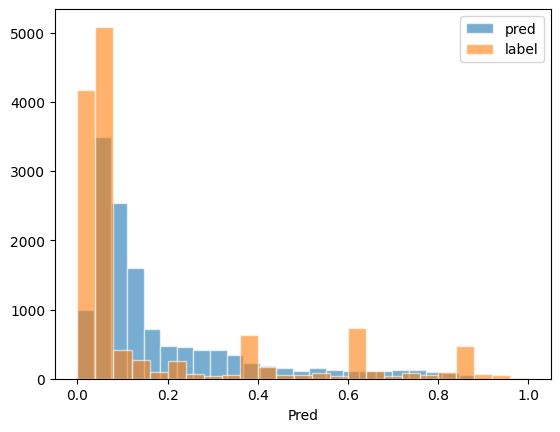

In [24]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [25]:
pred_df = test.copy()
pred_df["pred"] = np.mean(preds, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_SWIR1,knn_TIRS2,knn_NBR2,knn_NLI,knn_RDVI,knn_DSWI,knn_Alteration,knn_sunElevation,knn_AVI,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855,0.092336
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.858577,8.814009,0.625434,0.658823,-1.330266,2.717712,4.433743,53.323551,-13.141754,0.126525
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.372711,8.837255,0.707265,0.883218,-1.047965,2.010201,6.189369,53.999192,-15.260981,0.293431
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080518
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142374
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087484
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855,0.363035
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142381


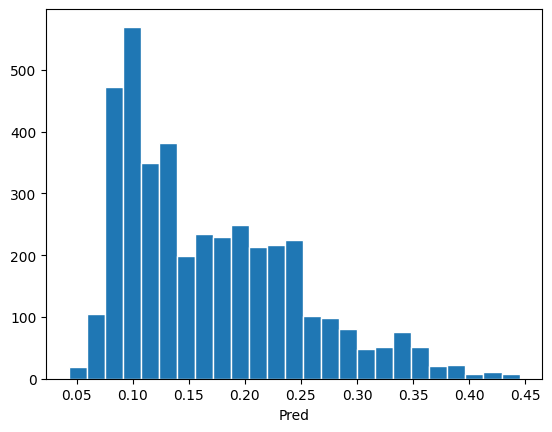

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_SWIR1,knn_TIRS2,knn_NBR2,knn_NLI,knn_RDVI,knn_DSWI,knn_Alteration,knn_sunElevation,knn_AVI,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855,0.092336
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.858577,8.814009,0.625434,0.658823,-1.330266,2.717712,4.433743,53.323551,-13.141754,0.126525
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.372711,8.837255,0.707265,0.883218,-1.047965,2.010201,6.189369,53.999192,-15.260981,0.293431
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080518
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142374
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087484
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,2.318460,8.838449,0.722703,0.848795,-1.239537,1.984526,6.416499,53.999192,-17.434855,0.363035
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142381


In [26]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_SEEDAVERAGE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [27]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, f'test_pred_CTB_seed{CFG.seed}_ver{CFG.ver}.csv'))
_oof.to_csv(os.path.join(OUTPUT_DIR, f'OOF_CTB_seed{CFG.seed}_ver{CFG.ver}.csv'))